<a href="https://colab.research.google.com/github/paul6598/AI_practice/blob/main/240419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data #데이터셋 api command

Saving kaggle.json to kaggle.json
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 28.7MB/s]


In [2]:
!unzip -o /content/daily-climate-time-series-data.zip -d /content/data_set

Archive:  /content/daily-climate-time-series-data.zip
  inflating: /content/data_set/DailyDelhiClimateTest.csv  
  inflating: /content/data_set/DailyDelhiClimateTrain.csv  


In [3]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
"""
LSTM은 데이터 전처리가 필요하다.
단순히 시간순으로 정렬된 데이터를 원하는 timestep만큼 잘라서 한칸씩 내려오며 각 window를 모은 data를
input으로 사용해야 함. y값도 원하는 시점의 data를 잘라서 그걸 이용하면 됨.
생각보다 어렵다...ㅜ
"""

In [4]:
train_data = pd.read_csv("/content/data_set/DailyDelhiClimateTrain.csv")
test_data = pd.read_csv("/content/data_set/DailyDelhiClimateTest.csv")

In [5]:
print(train_data)
print(test_data)

            date   meantemp    humidity  wind_speed  meanpressure
0     2013-01-01  10.000000   84.500000    0.000000   1015.666667
1     2013-01-02   7.400000   92.000000    2.980000   1017.800000
2     2013-01-03   7.166667   87.000000    4.633333   1018.666667
3     2013-01-04   8.666667   71.333333    1.233333   1017.166667
4     2013-01-05   6.000000   86.833333    3.700000   1016.500000
...          ...        ...         ...         ...           ...
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 5 columns]
           date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.500000  77.222222    2.894444   101

In [25]:
train_data = train_data.drop("date",axis=1)
test_data = test_data.drop("date",axis=1)

In [121]:
train_data.min()

meantemp         6.000000
humidity        13.428571
wind_speed       0.000000
meanpressure    -3.041667
dtype: float64

In [28]:
train_data

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
1457,17.217391,68.043478,3.547826,1015.565217
1458,15.238095,87.857143,6.000000,1016.904762
1459,14.095238,89.666667,6.266667,1017.904762
1460,15.052632,87.000000,7.325000,1016.100000


In [29]:
train_data["meantemp"][0]

10.0

In [7]:
train_data.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
#구현해볼 모델 : 지난 14일간의 기후정보를 통해 일평균기온을 예측

In [50]:
train_x = []
train_y = []
test_x = []
test_y = []

predict = 1
train_step = 14
train_size = train_data.shape[0] #1462
test_size = test_data.shape[0] #114

In [51]:
#train 데이터는 0~13 (y값 14) >>  1447~1460(y값 1461)

for i in range(train_size - train_step - predict): #1462-14-1 = 1447
  train_x.append(train_data.loc[i:i+train_step-1])
  train_y.append(train_data["meantemp"][i+train_step])

In [76]:
for i in range(test_size - train_step - predict): #1462-14-1 = 1447
  test_x.append(test_data.loc[i:i+train_step-1])
  test_y.append(test_data["meantemp"][i+train_step])


In [52]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [77]:
test_x = np.array(test_x)
test_y = np.array(test_y)

In [78]:
print(test_x.shape)

(99, 14, 4)


In [53]:
print(train_x.shape)
print(train_y.shape)

(1447, 14, 4)
(1447,)


In [112]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (train_step,4), activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(32, input_shape = (train_step,4), activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 14, 128)           68096     
                                                                 
 dropout_9 (Dropout)         (None, 14, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 88737 (346.63 KB)
Trainable params: 88737 (346.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
model.compile(optimizer="adam",loss="mae",metrics=["mean_squared_error"])

In [114]:
early_stopping = EarlyStopping(monitor="val_loss",patience=15)

In [115]:
history = model.fit(train_x, train_y,
                    batch_size=30,
                    epochs = 1000,
                    verbose = 1,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
39/39 [==============================] - 6s 55ms/step - loss: 21.3497 - mean_squared_error: 512.2252 - val_loss: 23.2908 - val_mean_squared_error: 573.2936
Epoch 2/1000
39/39 [==============================] - 1s 29ms/step - loss: 17.2294 - mean_squared_error: 350.2917 - val_loss: 20.4086 - val_mean_squared_error: 447.3575
Epoch 3/1000
39/39 [==============================] - 1s 38ms/step - loss: 14.9418 - mean_squared_error: 277.5495 - val_loss: 18.6332 - val_mean_squared_error: 378.0511
Epoch 4/1000
39/39 [==============================] - 2s 44ms/step - loss: 13.4183 - mean_squared_error: 233.5004 - val_loss: 17.1609 - val_mean_squared_error: 325.3549
Epoch 5/1000
39/39 [==============================] - 1s 29ms/step - loss: 12.1054 - mean_squared_error: 195.8260 - val_loss: 15.8138 - val_mean_squared_error: 280.9360
Epoch 6/1000
39/39 [==============================] - 1s 27ms/step - loss: 11.0804 - mean_squared_error: 168.8316 - val_loss: 14.6255 - val_mean_squared_er

,meantemp,humidity,wind_speed,meanpressure
0,15.913043,85.869565,2.743478,59.000000
1,18.500000,77.222222,2.894444,1018.277778
2,17.111111,81.888889,4.016667,1018.333333
3,18.700000,70.050000,4.545000,1015.700000
4,18.388889,74.944444,3.300000,1014.333333
5,19.318182,79.318182,8.681818,1011.772727
6,14.708333,95.833333,10.041667,1011.375000
7,15.684211,83.526316,1.950000,1015.550000
8,14.571429,80.809524,6.542857,1015.952381
9,12.111111,71.944444,9.361111,1016.888889


In [84]:
print(test_x.shape)
print(test_y.shape)

(99, 14, 4)
(99,)


In [99]:
test_x[0]

array([[  15.91304348,   85.86956522,    2.74347826,   59.        ],
       [  18.5       ,   77.22222222,    2.89444444, 1018.27777778],
       [  17.11111111,   81.88888889,    4.01666667, 1018.33333333],
       [  18.7       ,   70.05      ,    4.545     , 1015.7       ],
       [  18.38888889,   74.94444444,    3.3       , 1014.33333333],
       [  19.31818182,   79.31818182,    8.68181818, 1011.77272727],
       [  14.70833333,   95.83333333,   10.04166667, 1011.375     ],
       [  15.68421053,   83.52631579,    1.95      , 1015.55      ],
       [  14.57142857,   80.80952381,    6.54285714, 1015.95238095],
       [  12.11111111,   71.94444444,    9.36111111, 1016.88888889],
       [  11.        ,   72.11111111,    9.77222222, 1016.77777778],
       [  11.78947368,   74.57894737,    6.62631579, 1016.36842105],
       [  13.23529412,   67.05882353,    6.43529412, 1017.52941176],
       [  13.2       ,   74.28      ,    5.276     , 1018.84      ]])

In [108]:
a = model.predict(np.array([test_x[0]]))

1/1 [==============================] - 0s 53ms/step


In [111]:
a[0][0]

22.423103

In [116]:
pred_y = []
real_y = []
test_len = test_x.shape[0]
for i in range(test_len):
  pred_y.append(model.predict(np.array([test_x[i]]))[0][0])
  real_y.append(test_y[i])
  history = model.fit(np.array([test_x[i]]), np.array([test_y[i]]),
                    epochs = 1,
                    verbose = 1,)



1/1 [==============================] - 0s 20ms/step - loss: 7.8892 - mean_squared_error: 62.2388


실제 기온:  16.4348 예측 기온:  25.6972 오차율:  56.3587 %
실제 기온:  14.65 예측 기온:  25.6885 오차율:  75.3479 %
실제 기온:  11.7222 예측 기온:  25.668 오차율:  118.9688 %
실제 기온:  13.0417 예측 기온:  25.6364 오차율:  96.5728 %
실제 기온:  14.619 예측 기온:  25.5968 오차율:  75.0924 %
실제 기온:  15.2632 예측 기온:  25.5494 오차율:  67.3925 %
실제 기온:  15.3913 예측 기온:  25.4954 오차율:  65.6483 %
실제 기온:  18.44 예측 기온:  25.4354 오차율:  37.9358 %
실제 기온:  18.1176 예측 기온:  25.3694 오차율:  40.0259 %
실제 기온:  18.3478 예측 기온:  25.2993 오차율:  37.8869 %
실제 기온:  21.0 예측 기온:  25.2209 오차율:  20.0995 %
실제 기온:  16.1786 예측 기온:  25.1419 오차율:  55.4022 %
실제 기온:  16.5 예측 기온:  25.06 오차율:  51.8789 %
실제 기온:  14.8636 예측 기온:  24.9773 오차율:  68.0429 %
실제 기온:  15.6667 예측 기온:  24.8933 오차율:  58.8937 %
실제 기온:  16.4444 예측 기온:  24.8084 오차율:  50.8617 %
실제 기온:  16.125 예측 기온:  24.7198 오차율:  53.301 %
실제 기온:  15.25 예측 기온:  24.6307 오차율:  61.5128 %
실제 기온:  17.0909 예측 기온:  24.5391 오차율:  43.58 %
실제 기온:  15.6364 예측 기온:  24.448 오차율:  56.3538 %
실제 기온:  18.7 예측 기온:  24.3557 오차율:  30.2442 %
실제 기온:  18.6316

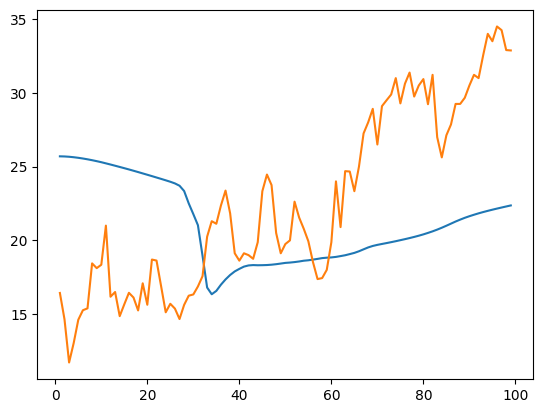

In [118]:
x_num = []
for i in range(99):
  print("실제 기온: ",round(real_y[i],4), "예측 기온: ", round(pred_y[i],4), "오차율: ",round(100*(abs((real_y[i]-pred_y[i])/real_y[i])),4),"%")
  x_num.append(i+1)

plt.plot(x_num, pred_y, label="predict")
plt.plot(x_num, real_y, label="real")

In [105]:
type(real_y[0])

numpy.float64